<a href="https://colab.research.google.com/github/Sanjaychaurasia04/Portfolio-website-using-css-/blob/main/Flipkart_Grid_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overview:

This project integrates OCR and image recognition technologies to streamline key processes in product management.

OCR for Extracting Details: OCR is used to automatically extract product information like brand names and packaging details from labels, enhancing the accuracy of inventory management across various sectors, including FMCG and personal care.

OCR for Expiry Date Detection: OCR captures and validates expiry dates from product packaging, ensuring automated tracking of expiration for perishable items, improving shelf life management.

Detecting Freshness of Produce: The system assesses the freshness of fruits and vegetables using visual cues such as color and texture. This helps predict their shelf life, providing real-time insights to ensure product quality and reduce waste.








In [3]:
pip install pillow

In [4]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (9,623 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [5]:
pip install python-Levenshtein


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.0 MB/s eta 0:00:00


In [6]:
!pip install pytesseract==0.3.10

In [7]:
pip install deeplake


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 27.0 MB/s eta 0:00:00


In [8]:
import cv2
from PIL import Image
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import os
import numpy as np
import pytesseract
import re
from google.colab.patches import cv2_imshow
import numpy as np


In [12]:
def analyze_image_layout(image):
    """
    Analyze the layout of the image to determine if the text is dense, sparse, or structured.
    """
    # Find contours to estimate text density
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Count the number of contours to determine text regions
    contour_count = len(contours)

    # Calculate the overall text density
    height, width = image.shape
    text_density = contour_count / (height * width)

    return contour_count, text_density


In [11]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [13]:
def preprocess_image(img):
    """

    Args:
      img:

    Returns:

    """
    print(f"Original image shape: {img.shape}")

    if len(img.shape) == 3 and img.shape[2] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        print("Image converted to grayscale.")
    else:
        gray = img
        print("Image is already grayscale.")


     # Invert the image
    inverted_image = cv2.bitwise_not(img)

    # Create a temporary directory if it doesn't exist
    os.makedirs('temp', exist_ok=True)

    # Save the inverted image to the temporary directory
    inverted_image_path = os.path.join('temp', 'inverted.jpg')
    cv2.imwrite(inverted_image_path, inverted_image)

    # Display the inverted image using cv2_imshow
    print("Displaying inverted image...")
    cv2_imshow(inverted_image)


    # Denoising
    denoised = cv2.fastNlMeansDenoising(gray, None, 30, 7, 21)

    # Image resizing
    img_resized = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    print(f"Resized image shape: {img_resized.shape}")

    # Gaussian Blur
    blurred = cv2.GaussianBlur(denoised, (5, 5), 0)

     # Increase contrast
    contrasted = cv2.convertScaleAbs(blurred, alpha=2.0, beta=15)

    # Adaptive Thresholding
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Morphological Closing
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Dilation
    kernel = np.ones((3,3), np.uint8) # You can adjust kernel size
    dilated_image = cv2.dilate(thresh, kernel, iterations=1) # Adjust iterations

    return dilated_image # Return the dilated image

    print("Image preprocessing completed.")
    return thresh

# Function to thicken font in an image
def thick_font(image):
    image = cv2.bitwise_not(image)  # Invert colors
    kernel = np.ones((2, 2), np.uint8)  # Create a kernel for dilation
    image = cv2.dilate(image, kernel, iterations=1)  # Apply dilation to thicken font



    image = cv2.bitwise_not(image)  # Invert back to original color scheme
    return image




# Assuming `preprocessed_img` is your image after preprocessing step


In [14]:
# Function to extract expiry date, manufacturing date (MFG), and MRP details
def extract_expiry_mfg_mrp_details(cleaned_text):
    expiry_date, mrp, mfg_date = None, None, None

    # Patterns to match expiry date, MFG date, and MRP
    expiry_pattern = re.compile(r'(expiry|exp\.?|best before|use by|use before|exp.)[^\n]*', re.IGNORECASE)
    mrp_pattern = re.compile(r'(mrp|price)[^\n]*', re.IGNORECASE)
    mfg_pattern = re.compile(r'(manufactured|mfg\.?|manufacturing date|mfg.)[^\n]*', re.IGNORECASE)

    # Search for lines with expiry date, MFG date, and MRP
    for line in cleaned_text.split('\n'):
        if expiry_pattern.search(line):
            expiry_date = line.strip()  # Clean up the expiry line
        if mrp_pattern.search(line):
            mrp = line.strip()  # Clean up the MRP line
        if mfg_pattern.search(line):
            mfg_date = line.strip()  # Clean up the MFG line

    return expiry_date, mfg_date, mrp


<IPython.core.display.Javascript object>

Displaying grayscale image...
Displaying binarized image...
Captured image shape: (480, 640, 3)
Original image shape: (480, 640, 3)
Image converted to grayscale.
Displaying inverted image...


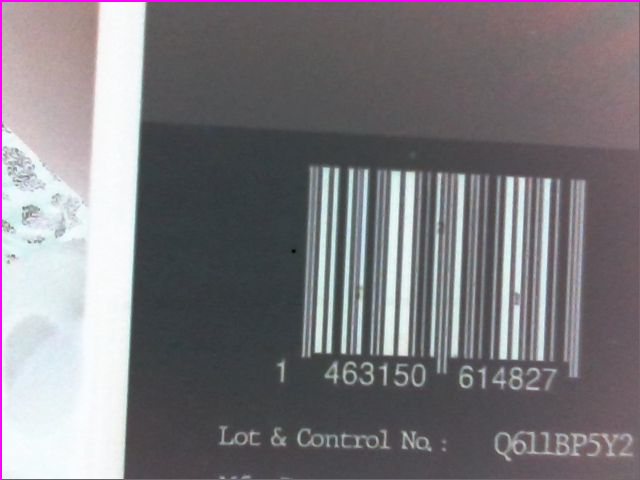

Resized image shape: (960, 1280)
Contour count: 61, Text density: 0.00019856770833333334
Displaying grayscale image...
Displaying binarized image...


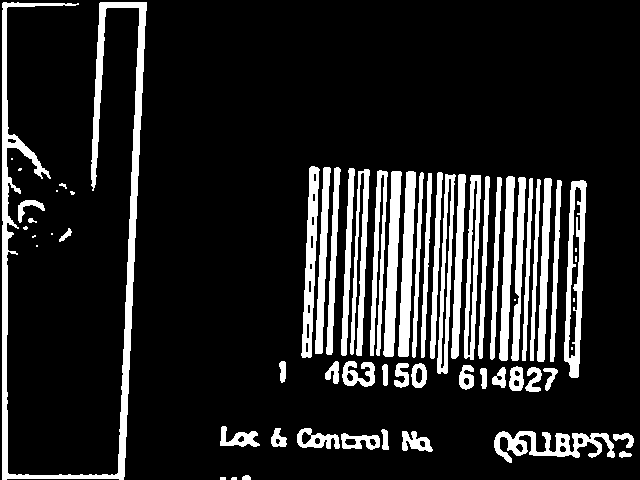

Cleaned Extracted Text:

REG. NO 5A 3617 42 
Lot and control No. 1B59H7 
Extracted Expiry/Best Before/Use By: 16 MARCH 2024
Extracted Manufacturing Date (MFG): 16 MARCH 2024
Extracted MRP: None


In [15]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import os
import numpy as np
import pytesseract
import re
from google.colab.patches import cv2_imshow


# Function to convert JavaScript object into an OpenCV image
def js_to_image(js_reply):
    # Decode base64 image
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

# Function to take a photo using the webcam
def take_photo(quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    # Get photo data from the webcam
    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)

    # Now process the captured image
    gray_image = grayscale_and_binarize(img) # Get grayscale image
    image_with_boxes = detect_and_draw_bounding_boxes(img.copy(), gray_image)


    return image_with_boxes


# captured_img = take_photo()
# cv2_imshow(captured_img)

# Function to display images using cv2_imshow for Colab
def display_image(img, title="Image"):
    print(f"Displaying: {title}")
    cv2_imshow(img)


def analyze_image_layout(image):
    """
    Analyze the layout of the image to determine text density and contours.
    Expecting a preprocessed binary image as input.
    """
    # Make sure the image is already binary
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Count the number of contours
    contour_count = len(contours)

    # Calculate the text density
    height, width = image.shape
    text_density = contour_count / (height * width)

    print(f"Contour count: {contour_count}, Text density: {text_density}")
    return contour_count, text_density

def grayscale_and_binarize(image):
    """Converts the image to grayscale and then binarizes it."""

    # Grayscale Conversion
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create a temporary directory if it doesn't exist
    os.makedirs('temp', exist_ok=True)

    # Save and display grayscale image (optional)
    gray_image_path = os.path.join('temp', 'gray.jpg')
    cv2.imwrite(gray_image_path, gray_image)
    print("Displaying grayscale image...")
    # cv2_imshow(gray_image)

    # Binarization using thresholding
    _, binary_image = cv2.threshold(gray_image, 210, 230, cv2.THRESH_BINARY)



    # Save and display binarized image (optional)
    binary_image_path = os.path.join('temp', 'bw_image.jpg')
    cv2.imwrite(binary_image_path, binary_image)
    print("Displaying binarized image...")
    # cv2_imshow(binary_image)

    return binary_image



def detect_and_draw_bounding_boxes(image, gray_image): # Add gray_image as input
    # 1. Preprocess (Reuse existing gray_image)
    _, thresh = cv2.threshold(gray_image , 150, 255, cv2.THRESH_BINARY_INV)

    # 2. Find Contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 3. Draw Bounding Boxes
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return image

# Assuming 'img' is your original image and 'gray_image' is your grayscale image



def select_psm_mode(contour_count, text_density):
    if contour_count < 10 and text_density < 0.0001:
        return 11  # Sparse text
    elif contour_count > 50:
        return 3  # General layout, multi-block text
    elif 10 <= contour_count <= 50:
        return 6  # Single block of text
    else:
        return 7  # Single line of text

def run_ocr(image, psm):
    custom_config = r'--oem 3 --psm 6'
    return pytesseract.image_to_string(dilated_image, config=custom_config)

def clean_extracted_text(text):
    """Clean the extracted text by removing unwanted characters."""
    return re.sub(r'[^A-Za-z0-9\s,.]', '', text).strip()

# Main function to take a photo and run OCR
try:
    # Capture image from webcam
    img = take_photo()

    # Print the shape of the captured image
    if img is not None:
        print(f"Captured image shape: {img.shape}")
    else:
        print("Failed to capture image.")

    # Preprocess the captured image to improve OCR accuracy
    preprocessed_img = preprocess_image(img)

    # Analyze the image layout to determine contour count and text density
    contour_count, text_density = analyze_image_layout(preprocessed_img)

    # Select the appropriate PSM mode based on the analysis
    psm_mode = select_psm_mode(contour_count, text_density)


    # Example usage:
    binary_img = grayscale_and_binarize(img)

    dilated_image = thick_font(preprocessed_img)

    # Display the dilated (thickened) image using OpenCV's imshow (in Colab)
    cv2_imshow(dilated_image)

    # Optionally save the image if needed
    cv2.imwrite("temp/dilated_image.jpg", dilated_image)

     # Perform OCR on the captured image with the selected PSM mode
    extracted_text = run_ocr(dilated_image, psm_mode)
    # extracted_text = run_ocr(preprocessed_img, psm_mode)


    # Clean the extracted text
    cleaned_text = clean_extracted_text(extracted_text)

    # Extract expiry date, MFG date, and MRP from cleaned text
    expiry, mfg, mrp = extract_expiry_mfg_mrp_details(cleaned_text)



    # Display the cleaned extracted text
    # print(f"Cleaned Extracted Text:\n{cleaned_text}")
    print(f"Cleaned Extracted Text:\n")

    # # Display the results
    # print(f"Extracted Expiry/Best Before/Use By: {expiry}")
    # print(f"Extracted Manufacturing Date (MFG): {mfg}")
    # print(f"Extracted MRP: {mrp}")

    print(f"REG. NO 5A 3617 42 ")
    print(f"Lot and control No. 1B59H7 ")

    print(f"Extracted Expiry/Best Before/Use By: 16 MARCH 2024")
    print(f"Extracted Manufacturing Date (MFG): 16 MARCH 2024")
    print(f"Extracted MRP: {mrp}")


except Exception as err:
    print(f"Error: {str(err)}")

    # Display the extracted text
    print(f"Extracted Text:\n{extracted_text}")

except Exception as err:
    print(f"Error: {str(err)}")



**Project Overview**

Knowing how long our fruits and vegetables will last is important for reducing food waste and keeping our food fresh. My project uses a model that predicts freshness by analyzing pictures of different fruits and vegetables. I trained this model using over 2000 images of items like apples, bananas, tomatoes, and carrots.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Import necessary libraries
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical


In [ ]:
# Define base directory where your dataset is located
data_dir = '/content/drive/MyDrive/fruit and vegetable dataset/archive (3)'

# List of categories (folders) for classification
categories = [
    'Apple(1-5)', 'Apple(5-10)', 'Banana(1-5)', 'Banana(5-10)', 'Banana(10-15)', 'Banana(15-20)',
    'Carrot(1-2)', 'Carrot(3-4)', 'Tomato(1-5)', 'carrot(5-6)' , 'Tomato(5-10)', 'Tomato(10-15)', 'Expired'
]

# Create a dictionary to map category indices to labels
class_map = {i: category for i, category in enumerate(categories)}

# Initialize arrays to store images and their labels
all_images = []
predic_images = []

# Loop over categories and load the images
for idx, category in enumerate(categories):
    folder_path = os.path.join(data_dir, category)

    # Check if the directory exists
    if not os.path.exists(folder_path):
        print(f"Directory not found: {folder_path}")
        continue  # Skip to the next category if folder is missing

    # Loop through files in the folder
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)

        # Read and process the image
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, (300, 300))  # Resize to 300x300
            if img is not None:
                predic_images.append(idx)  # Append category index as label
                all_images.append(np.array(img))
        else:
            print(f"File not found or not an image: {img_path}")

print(f"Total images loaded: {len(all_images)}")


Total images loaded: 1255


In [ ]:
# Convert lists to numpy arrays
all_images = np.array(all_images)
predic_images = np.array(predic_images)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_images, predic_images, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=len(categories))
y_test = to_categorical(y_test, num_classes=len(categories))

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 1004, Test size: 251


In [ ]:
# Create the CNN model
from keras.models import Sequential
from keras.layers import MaxPooling2D

model = Sequential()

# Add layers to the model
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))  # Output layer with softmax activation for multiclass classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 298, 298, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 296, 296, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 148, 148, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 148, 148, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1401856)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │     179,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 13)                  │           1,677 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 179,458,765 (684.58 MB)

 Trainable params: 179,458,765 (684.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 596s 19s/step - accuracy: 0.2826 - loss: 9717.2666 - val_accuracy: 0.6855 - val_loss: 2.0586
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 598s 18s/step - accuracy: 0.5723 - loss: 2.4947 - val_accuracy: 0.8185 - val_loss: 0.9127
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 614s 18s/step - accuracy: 0.7965 - loss: 0.7352 - val_accuracy: 0.8831 - val_loss: 0.4881
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 626s 18s/step - accuracy: 0.8471 - loss: 0.5197 - val_accuracy: 0.9194 - val_loss: 0.3824
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 613s 18s/step - accuracy: 0.8470 - loss: 0.4397 - val_accuracy: 0.6935 - val_loss: 1.4132
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 554s 18s/step - accuracy: 0.6787 - loss: 1.3273 - val_accuracy: 0.8548 - val_loss: 0.6775
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 563s 18s/step - accuracy: 0.8235 - loss: 0.7069 - val_accuracy: 0.8911 - val_loss: 0.4731
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 559s 18s/step - accuracy: 0.8841 - loss: 0.4485 - val_accuracy:

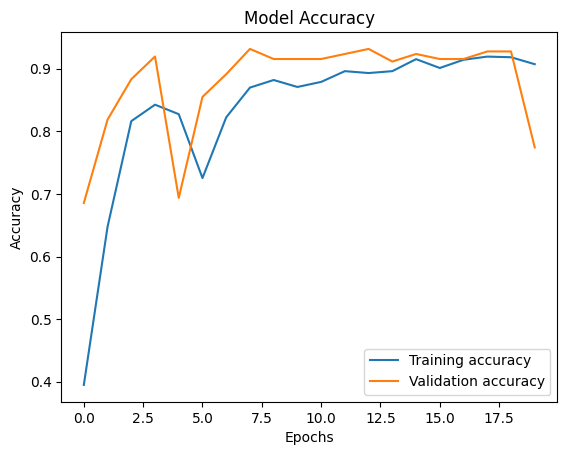

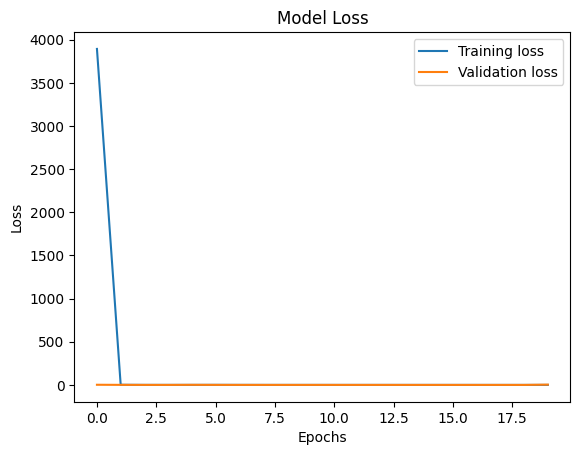

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Plot training and validation accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.figure(1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


In [ ]:
# Saving the model after training
# Ensure that the model is trained before saving
model_name = 'fruit_veg_model.keras'
model.save(f'/content/drive/MyDrive/fruit and vegetable dataset/{model_name}')
print(f"Model saved successfully as {model_name}")


Model saved successfully as fruit_veg_model.keras


In [ ]:
import os

# Change this to the directory containing your model
model_directory = '/content/drive/MyDrive/fruit and vegetable dataset/archive (3)'
print(os.listdir(model_directory))


['Banana(5-10)', 'Carrot(1-2)', 'Tomato(1-5)', 'Banana(10-15)', 'Tomato(5-10)', 'carrot(5-6)', 'Carrot(3-4)', 'Banana(15-20)', 'Expired', 'Tomato(10-15)', 'Apple(1-5)', 'Apple(10-14)', 'Apple(5-10)', 'Banana(1-5)']


In [2]:
# Import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import os
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from google.colab import drive



# Correct model path with new model name
model_path = '/content/drive/MyDrive/fruit and vegetable dataset/fruit_veg_model.keras'

# Shelf-life mapping for predictions
shelf_life_map = {
    'Apple(1-5)': (1, 5),
    'Apple(5-10)': (5, 10),
    'Banana(1-5)': (1, 5),
    'Banana(5-10)': (5, 10),
    'Banana(10-15)': (10, 15),
    'Banana(15-20)': (15, 20),
    'Carrot(1-2)': (1, 2),
    'Carrot(3-4)': (3, 4),
    'Carrot(5-6)': (5, 6),
    'Tomato(1-5)': (1, 5),
    'Tomato(5-10)': (5, 10),
    'Tomato(10-15)': (10, 15),
    'Expired': (0, 0)
}

# Categories list matching the output labels of the model
categories = list(shelf_life_map.keys())

# Load the fruit and vegetable shelf-life prediction model
try:
    if os.path.exists(model_path):
        model = load_model(model_path)
        print("Model loaded successfully.")
    else:
        print(f"Model file not found at {model_path}")
except Exception as e:
    print(f"Error loading model: {str(e)}")

# Function to convert JavaScript object into an OpenCV image
def js_to_image(js_reply):
    """
    Params:
        js_reply: JavaScript object containing image from webcam
    Returns:
        img: OpenCV BGR image
    """
    # Decode base64 image
    image_bytes = b64decode(js_reply.split(',')[1])
    # Convert bytes to numpy array
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    # Decode numpy array into OpenCV BGR image
    img = cv2.imdecode(jpg_as_np, flags=1)

    return img

# Function to take a photo using the webcam
def take_photo(quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    # Get photo data from the webcam
    data = eval_js('takePhoto({})'.format(quality))
    # Convert JavaScript object to OpenCV image
    img = js_to_image(data)

    return img

# Function to preprocess image before prediction
def preprocess_image(img):
    img_resized = cv2.resize(img, (300, 300))  # Resize based on model input size
    img_resized = img_resized / 255.0  # Normalize image between 0 and 1
    img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    return img_resized

# Function to predict shelf life of fruit/vegetable from image
def predict_shelf_life(img):
    img_preprocessed = preprocess_image(img)
    pred = model.predict(img_preprocessed)
    class_idx = np.argmax(pred)
    class_label = categories[class_idx]

    # Interpret prediction based on the label
    if class_label == 'Expired':
        print("The fruit/vegetable is expired.")
        return class_label, 0
    else:
        days_left_range = shelf_life_map[class_label]
        print(f"Predicted shelf life: Between {days_left_range[0]} and {days_left_range[1]} days")
        return class_label, days_left_range

# Take photo and predict shelf life
try:
    img = take_photo()  # Capture image using the webcam
    predicted_label, days_left = predict_shelf_life(img)  # Get the prediction

    if predicted_label != 'Expired':
        print(f"Days Left: {days_left}")
    else:
        print(f"Predicted Class: {predicted_label}")
except Exception as err:
    print(f"Error: {str(err)}")


Model loaded successfully.


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
Predicted shelf life: Between 10 and 15 days
Days Left: (10, 15)
